# Pipeline for High-z Radio Galaxies 28: SHAP values for base models in prediction

In this notebook, we aim to obtain a SHAP analysis for a sub-sample of our catalogue in the base-learners used for predictions.  
It is possible to select either a random sample from the predicted pipeline (non-star, radio AGN) or high-redshift sources,  
regardless of their predicted values.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd
import shap
import fasttreeshap

In [2]:
mpl.rcdefaults()

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

In [4]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
            return sample_df.columns.tolist()
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
            return sample_df.columns.tolist()

In [5]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

In [6]:
def plot_shap_beeswarm(pred_type, model_name, shap_values, cmap=plt.get_cmap('cmr.guppy'), ax_factor=0.75):
    if np.ndim(shap_values.values) == 2:
        shap.plots.beeswarm(copy.deepcopy(shap_values), log_scale=False, show=False, color_bar=False,
                            color=selected_color, max_display=len(shap_values.feature_names), alpha=1.0)
    elif np.ndim(shap_values.values) > 2:
        shap.plots.beeswarm(copy.deepcopy(shap_values)[:, :, 1], log_scale=False, show=False, color_bar=False,
                            color=cmap, max_display=len(shap_values.feature_names), alpha=1.0)
    _, h = plt.gcf().get_size_inches()
    m = cm.ScalarMappable(cmap=cmap)
    cb = plt.colorbar(m, ticks=[0, 1], aspect=100)
    cb.set_ticklabels([shap.plots._labels.labels['FEATURE_VALUE_LOW'], shap.plots._labels.labels['FEATURE_VALUE_HIGH']])
    cb.set_label(shap.plots._labels.labels["FEATURE_VALUE"], size=16, labelpad=-20)
    cb.ax.tick_params(labelsize=16, length=0)
    cb.set_alpha(1)
    cb.outline.set_visible(False)
    bbox = cb.ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())
    plt.gca().tick_params('x', labelsize=14)
    plt.gca().xaxis.get_offset_text().set_fontsize(14)
    plt.gca().xaxis.get_offset_text().set_position((0,1))
    plt.gca().tick_params('y', labelsize=20)
    plt.gca().xaxis.label.set_size(20)
    plt.title(f'{pred_type}: Base-learner - {model_name}', fontsize=16)
    plt.gcf().set_size_inches(h * ax_factor, h * ax_factor *3/2)
    plt.tight_layout()

In [7]:
def plot_shap_decision(pred_type, model_name, shap_values, shap_explainer, col_names, ax, link, cmap=plt.get_cmap('cmr.guppy')):
    if np.ndim(shap_values.values) == 2:
        shap.plots.decision(base_value=shap_explainer.expected_value,
                            shap_values=shap_values.values,
                            feature_names=col_names.to_list(),
                            link=link, plot_color=cmap,
                            highlight=None, auto_size_plot=False,
                            show=False, xlim=None,
                            feature_display_range=slice(-1, -(len(shap_values.feature_names) +1), -1))
    if np.ndim(shap_values.values) > 2:
        shap.plots.decision(base_value=shap_explainer.expected_value[-1],
                            shap_values=(shap_values.values)[:, :, 1],
                            feature_names=col_names.to_list(),
                            link='logit', plot_color=cmap,
                            highlight=None, auto_size_plot=False,
                            show=False, xlim=None,
                            feature_display_range=slice(-1, -(len(shap_values.feature_names) +1), -1))
    ax.tick_params('x', labelsize=14)
    ax.xaxis.get_offset_text().set_fontsize(14)
    #ax1.xaxis.get_offset_text().set_position((0,1))
    ax.tick_params('y', labelsize=20)
    # plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    ax.xaxis.label.set_size(20)
    plt.title(f'{pred_type}: Base-learner - {model_name}', fontsize=16)
    plt.tight_layout()

---

In [8]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = True

### Load data

In [9]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

Any of the available areas could be used. But we aim to Stripe 82 since we want to understand, with SHAP, predictions and not training.

In [10]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS' 

In [11]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [12]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [13]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [14]:
full_catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369093 entries, 0 to 369092
Data columns (total 50 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   RA_ICRS       369093 non-null  float32
 1   DE_ICRS       369093 non-null  float32
 2   Name          369093 non-null  object 
 3   TYPE          369093 non-null  object 
 4   Z             2930 non-null    float32
 5   zsp           665 non-null     float32
 6   spCl          369093 non-null  object 
 7   band_num      369093 non-null  int64  
 8   radio_detect  369093 non-null  bool   
 9   is_str        369093 non-null  int64  
 10  is_AGN        369093 non-null  int64  
 11  is_SDSS_gal   369093 non-null  int64  
 12  is_gal        369093 non-null  int64  
 13  W1mproPM      369093 non-null  float32
 14  W2mproPM      369093 non-null  float32
 15  gmag          369093 non-null  float32
 16  rmag          369093 non-null  float32
 17  imag          369093 non-null  float32
 18  zmag

Create features with class and combined redshift.

In [15]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [16]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

In [17]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [18]:
seed                                = 42

### Load models

In [19]:
if load_models_flag:
    if use_zeroth_model:
        star_clf    = pyc.load_model('models/classification_star_no_star_jun_30_2022')  # star/no-star model
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        # redshift_reg_2  = pyr.load_model('models/regression_z_may_30_2022')  # to use on sources with predicted z >= 3.7
        redshift_reg_2  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7 + SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [20]:
if use_zeroth_model:
    threshold_star = 0.37441  # 0.5, 0.15688 from ROC AUC in train+test, 0.37441 from PR curve
threshold_AGN   = 0.3112  # 0.5, 0.3094 from ROC AUC in train+test, 0.3112 from PR curve
threshold_radio = 4.99972232e-01  # 0.5, 4.99972232e-01 from ROC AUC in train+test and PR curve

Predictions

In [21]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=threshold_star, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

In [22]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [23]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [24]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=6)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [25]:
redshift_lim    = 3.7
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [26]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

---

## Use SHAP

Flags to run on sub-set of base learners.

In [27]:
run_shap_AGN_base    = False
run_shap_radio_base  = False
run_shap_z_base      = False
run_shap_high_z_base = True

In [28]:
selected_color       = plt.get_cmap('cmr.guppy')  # cmr.pride, cet_CET_R3 cmr.wildfire cmr.guppy

#### Select relevant sources

In this case, high-redshift sources

In [29]:
run_high_z_flag    = False  # If True, run on original high-z sources. False for running on random set of predicted non-star, rAGN.

In [30]:
if run_high_z_flag:
    filter_selection = np.array(full_catalog_df.loc[:, 'Z'] >= redshift_lim)
elif not run_high_z_flag:
    filter_selection = np.ones_like(full_catalog_df.loc[:, 'Z']).astype(bool)

In [31]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [32]:
if run_shap_AGN_base:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [33]:
if run_shap_AGN_base:
    sample_size_AGN  = 1000
    sub_size_AGN = np.nanmin([sample_size_AGN, np.sum(filter_selection * filter_pred_no_str)])
    print(f'Number of selected elements: {sub_size_AGN:,}')

In [34]:
if run_shap_AGN_base:
    estimators_list_AGN = get_base_estimators_names(AGN_gal_clf)

In [35]:
if run_shap_AGN_base:
    reduced_data_AGN      = full_catalog_df.loc[filter_selection, get_final_column_names(AGN_gal_clf, full_catalog_df)].sample(n=sub_size_AGN, random_state=seed).copy()
    reduced_idx_AGN       = reduced_data_AGN.index
    reduced_cols_AGN_base = reduced_data_AGN.columns
    reduced_cols_AGN      = reduced_data_AGN.columns.insert(0, estimators_list_AGN[0])
    if len(estimators_list_AGN) > 1:
        for est_name in estimators_list_AGN[1::]:
            reduced_cols_AGN = reduced_cols_AGN.insert(0, est_name)

In [36]:
if run_shap_AGN_base:
    print('Running data pre-processing:\n')
    if isinstance(AGN_gal_clf, sklearn.pipeline.Pipeline):
        prep_steps = AGN_gal_clf.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_AGN = method.transform(reduced_data_AGN)
    reduced_data_AGN_df = pd.DataFrame(reduced_data_AGN, columns=reduced_cols_AGN, index=reduced_idx_AGN)

Use FastTreeSHAP package

In [37]:
if run_shap_AGN_base:
    explainers_AGN_base = {}
    for model, model_fit in zip(AGN_gal_clf.named_steps['trained_model'].estimators, AGN_gal_clf.named_steps['trained_model'].estimators_):
        explainers_AGN_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',
                                                                   model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [38]:
if run_shap_AGN_base:
    shap_values_AGN_base  = {}
    for model in explainers_AGN_base.keys():
        print(f'Working with base model {model}')
        shap_values_AGN_base[model] = explainers_AGN_base[model](reduced_data_AGN_df.drop(columns=estimators_list_AGN))

In [39]:
if run_shap_AGN_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_AGN_base.keys():
        print(f'{model: <10}\t: {explainers_AGN_base[model].expected_value[-1]: .4f}')

In [40]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        plot_shap_beeswarm('AGN/Galaxy class', model, shap_values_AGN_base[model])
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_AGN_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [41]:
if run_shap_AGN_base:
    for model in shap_values_AGN_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        plot_shap_decision('AGN/Galaxy class', model, shap_values_AGN_base[model], explainers_AGN_base[model], reduced_cols_AGN_base, ax1, 'logit')
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_decision_AGN_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [42]:
if run_shap_AGN_base:
    for count, model in enumerate(shap_values_AGN_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(AGN_gal_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_AGN_df.drop(columns=estimators_list_AGN))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((explainers_AGN_base[model].expected_value[-1] + shap_values_AGN_base[model].values[0].sum()).round(5))

---

#### SHAP - Radio detection model

In [43]:
if run_shap_radio_base:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [44]:
if run_shap_radio_base:
    sample_size_radio = 1000
    filter_pred_AGN   = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    sample_size_radio = np.nanmin([sample_size_radio, np.sum(filter_selection * filter_pred_AGN)])
    print(f'Number of selected elements: {sample_size_radio:,}')

In [45]:
if run_shap_radio_base:
    estimators_list_radio = get_base_estimators_names(radio_det_clf)

In [46]:
if run_shap_radio_base:
    reduced_data_radio      = full_catalog_df.loc[filter_selection,\
                                                  get_final_column_names(radio_det_clf, full_catalog_df)].sample(n=sample_size_radio, random_state=seed).copy()
    reduced_idx_radio       = reduced_data_radio.index
    reduced_cols_radio_base = reduced_data_radio.columns
    reduced_cols_radio      = reduced_data_radio.columns.insert(0, estimators_list_radio[0])
    if len(estimators_list_radio) > 1:
        for est_name in estimators_list_radio[1::]:
            reduced_cols_radio = reduced_cols_radio.insert(0, est_name)

In [47]:
if run_shap_radio_base:
    print('Running data pre-processing:\n')
    if isinstance(radio_det_clf, sklearn.pipeline.Pipeline):
        prep_steps = radio_det_clf.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_radio = method.transform(reduced_data_radio)
    reduced_data_radio_df = pd.DataFrame(reduced_data_radio, columns=reduced_cols_radio, index=reduced_idx_radio)

Use FastTreeSHAP package

In [48]:
if run_shap_radio_base:
    explainers_radio_base           = {}
    for model, model_fit in zip(radio_det_clf.named_steps['trained_model'].estimators, radio_det_clf.named_steps['trained_model'].estimators_):
        explainers_radio_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                     model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [49]:
if run_shap_radio_base:
    shap_values_radio_base = {}
    for model in explainers_radio_base.keys():
        print(f'Working with base model {model}')
        shap_values_radio_base[model] = explainers_radio_base[model](reduced_data_radio_df.drop(columns=estimators_list_radio))

In [50]:
if run_shap_radio_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_radio_base.keys():
        print(f'{model: <10}\t: {explainers_radio_base[model].expected_value[-1]: .4f}')

In [51]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        plot_shap_beeswarm('Radio detection', model, shap_values_radio_base[model])
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_radio_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [52]:
if run_shap_radio_base:
    for model in shap_values_radio_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        plot_shap_decision('Radio detection', model, shap_values_radio_base[model], explainers_radio_base[model], reduced_cols_radio_base, ax1, 'logit')
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_decision_radio_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [53]:
if run_shap_radio_base:
    for count, model in enumerate(shap_values_radio_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(radio_det_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_radio_df.drop(columns=estimators_list_radio))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((explainers_radio_base[model].expected_value[-1] + shap_values_radio_base[model].values[0].sum()).round(5))

---

#### SHAP - First redshift prediction model

In [54]:
if run_shap_z_base:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [55]:
if run_shap_z_base:
    sample_size_z    = 1000
    filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    sample_size_z    = np.nanmin([sample_size_z, np.sum(filter_selection * filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

In [56]:
if run_shap_z_base:
    estimators_list_z = get_base_estimators_names(redshift_reg)

In [57]:
if run_shap_z_base:
    reduced_data_z      = full_catalog_df.loc[filter_selection,\
                                              get_final_column_names(redshift_reg, full_catalog_df)].sample(n=sample_size_z, random_state=seed).copy()
    reduced_idx_z       = reduced_data_z.index
    reduced_cols_z      = reduced_data_z.columns
    reduced_cols_z_base = reduced_data_z.columns
    reduced_cols_z      = reduced_data_z.columns.insert(0, estimators_list_z[0])
    if len(estimators_list_z) > 1:
        for est_name in estimators_list_z[1::]:
            reduced_cols_z = reduced_cols_z.insert(0, est_name)

In [58]:
if run_shap_z_base:
    print('Running data pre-processing:\n')
    if isinstance(redshift_reg, sklearn.pipeline.Pipeline):
        prep_steps = redshift_reg.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_z = method.transform(reduced_data_z)
    reduced_data_z_df = pd.DataFrame(reduced_data_z, columns=reduced_cols_z, index=reduced_idx_z)

Use FastTreeSHAP package

In [59]:
if run_shap_z_base:
    explainers_z_base           = {}
    for model, model_fit in zip(redshift_reg.named_steps['trained_model'].estimators, redshift_reg.named_steps['trained_model'].estimators_):
        explainers_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                 model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [60]:
if run_shap_z_base:
    shap_values_z_base = {}
    for model in explainers_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_z_base[model] = explainers_z_base[model](reduced_data_z_df.drop(columns=estimators_list_z))

In [61]:
if run_shap_z_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value: .4f}')

In [62]:
if run_shap_z_base:
    for model in shap_values_z_base.keys():
        plot_shap_beeswarm('Redshift prediction', model, shap_values_z_base[model])
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [63]:
if run_shap_z_base:
    for model in shap_values_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        plot_shap_decision('Redshift prediction', model, shap_values_z_base[model], explainers_z_base[model], reduced_cols_z_base, ax1, 'identity')
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_decision_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [64]:
if run_shap_z_base:
    for count, model in enumerate(shap_values_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg.named_steps['trained_model'].estimators_[count].predict(reduced_data_z_df.drop(columns=estimators_list_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_z_base[model].expected_value[-1] + shap_values_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_z_base[model].expected_value + shap_values_z_base[model].values[0].sum()).round(5))

---

#### SHAP - Second redshift prediction model

In [65]:
if run_shap_high_z_base:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [66]:
if run_shap_high_z_base:
    sample_size_high_z      = 1000
    filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                np.array(full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim + redshift_tol))
    sample_size_high_z      = np.nanmin([sample_size_high_z, np.sum(filter_selection * filter_pred_rAGN_high_z)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

Number of selected elements: 163


In [67]:
if run_shap_high_z_base:
    estimators_list_high_z = get_base_estimators_names(redshift_reg_2)

In [68]:
if run_shap_high_z_base:
    reduced_data_high_z      = full_catalog_df.loc[filter_selection,\
                                                   get_final_column_names(redshift_reg_2, full_catalog_df)].sample(n=sample_size_high_z, random_state=seed).copy()
    reduced_idx_high_z       = reduced_data_high_z.index
    reduced_cols_high_z_base = reduced_data_high_z.columns
    reduced_cols_high_z      = reduced_data_high_z.columns.insert(0, estimators_list_high_z[0])
    if len(estimators_list_high_z) > 1:
        for est_name in estimators_list_high_z[1::]:
            reduced_cols_high_z = reduced_cols_high_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [69]:
if run_shap_high_z_base:
    print('Running data pre-processing:\n')
    if isinstance(redshift_reg_2, sklearn.pipeline.Pipeline):
        prep_steps = redshift_reg_2.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_high_z = method.transform(reduced_data_high_z)
    reduced_data_high_z_df = pd.DataFrame(reduced_data_high_z, columns=reduced_cols_high_z, index=reduced_idx_high_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


Use FastTreeSHAP package

In [70]:
if run_shap_high_z_base:
    explainers_high_z_base           = {}
    for model, model_fit in zip(redshift_reg_2.named_steps['trained_model'].estimators, redshift_reg_2.named_steps['trained_model'].estimators_):
        explainers_high_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                      model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [71]:
if run_shap_high_z_base:
    shap_values_high_z_base = {}
    for model in explainers_high_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_high_z_base[model] = explainers_high_z_base[model](reduced_data_high_z_df.drop(columns=estimators_list_high_z))

Working with base model gbr
Working with base model rf
Working with base model dt
Working with base model xgboost


In [72]:
if run_shap_high_z_base:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_high_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
gbr       	:  4.7502
rf        	:  4.7473
dt        	:  4.7502
xgboost   	:  4.7502


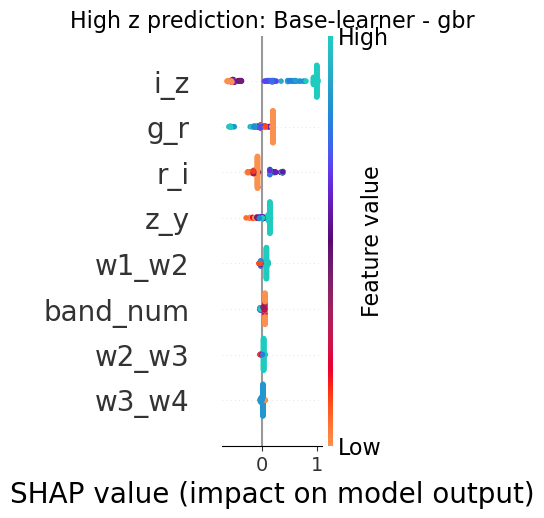

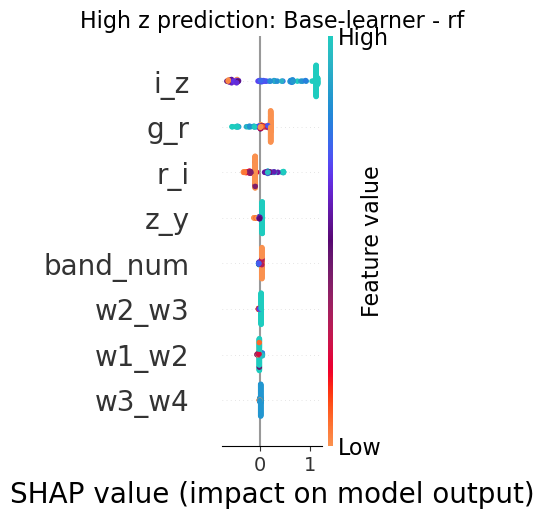

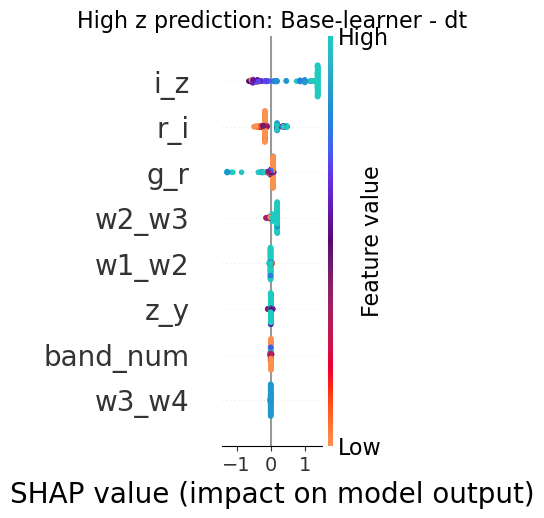

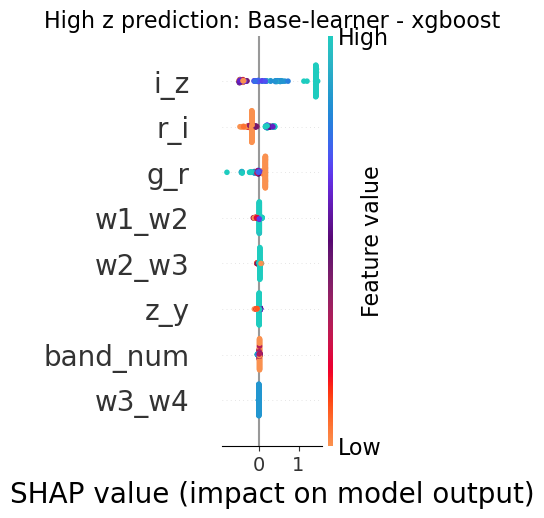

In [73]:
if run_shap_high_z_base:
    for model in shap_values_high_z_base.keys():
        plot_shap_beeswarm('High z prediction', model, shap_values_high_z_base[model])
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_high_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

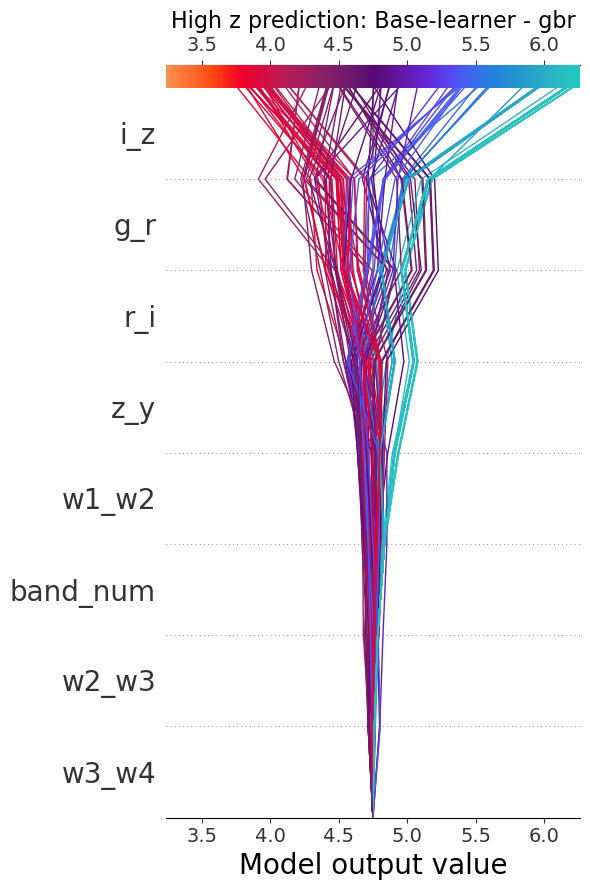

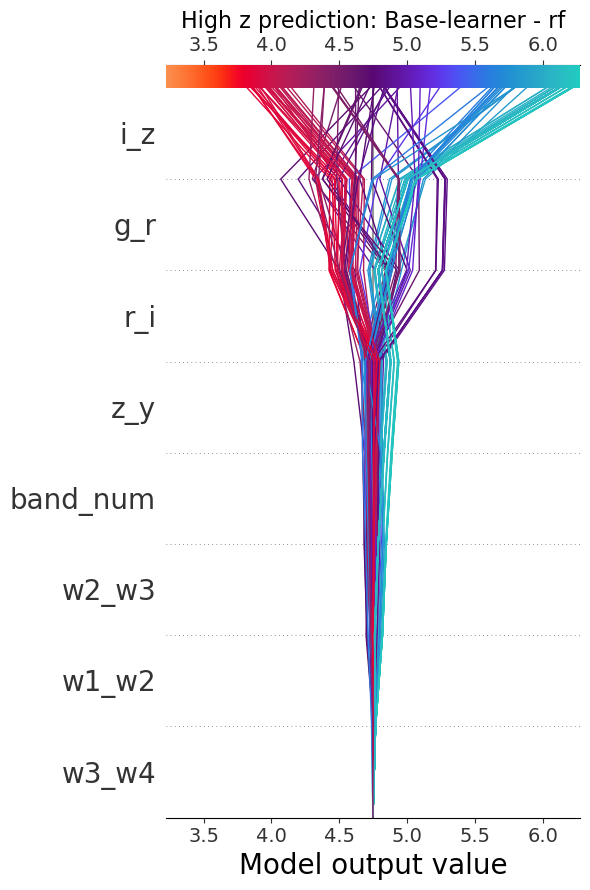

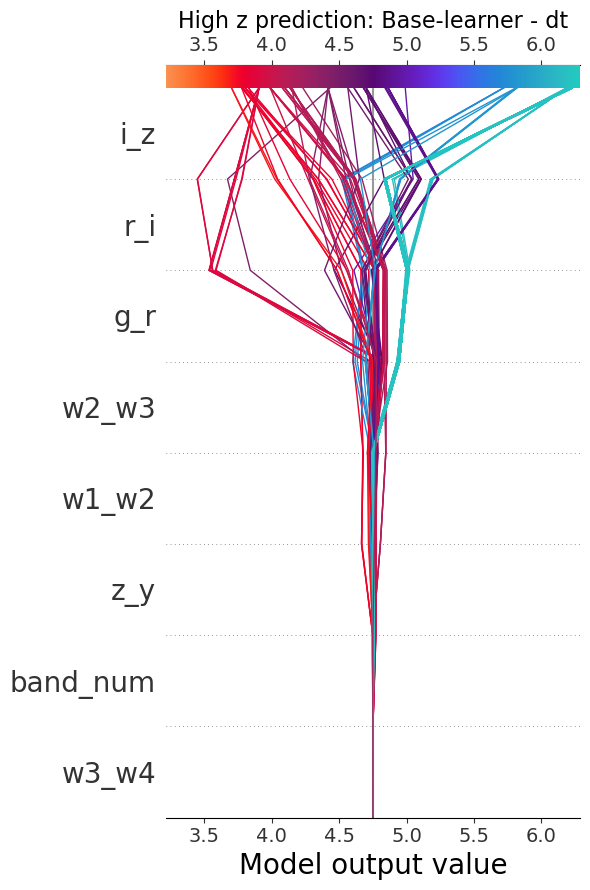

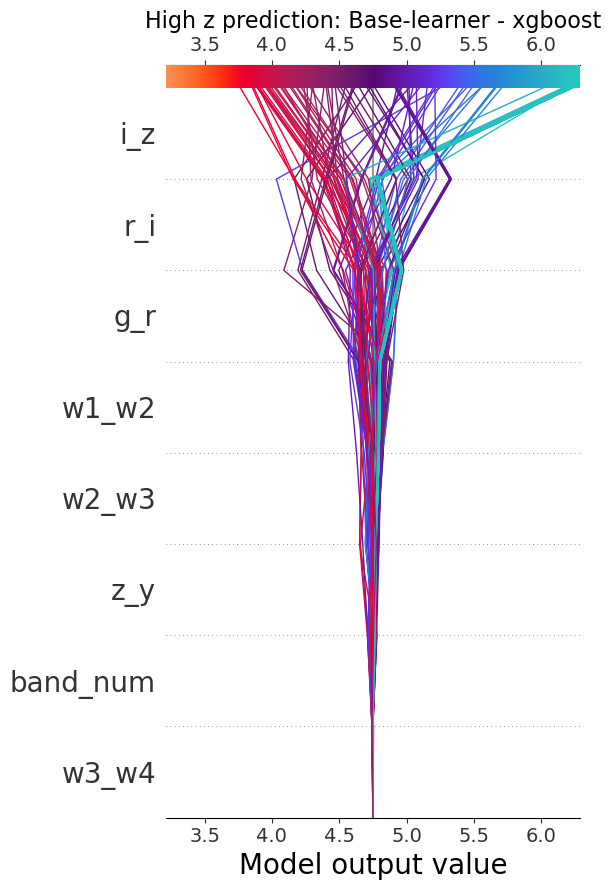

In [74]:
if run_shap_high_z_base:
    for model in shap_values_high_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        plot_shap_decision('High z prediction', model, shap_values_high_z_base[model],\
                           explainers_high_z_base[model], reduced_cols_high_z_base, ax1, 'identity')
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_decision_high_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [75]:
if run_shap_high_z_base:
    for count, model in enumerate(shap_values_high_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg_2.named_steps['trained_model'].estimators_[count].predict(reduced_data_high_z_df.drop(columns=estimators_list_high_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_high_z_base[model].expected_value[-1] + shap_values_high_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_high_z_base[model].expected_value + shap_values_high_z_base[model].values[0].sum()).round(5))


gbr:
4.03624
4.03624

rf:
4.03826
4.03826

dt:
4.148
4.148

xgboost:
3.99801
3.99801
